# 금융 데이터로 소득구간 예측하기

### <b> 금융 데이터의 속성</b>
금융 데이터의 특성
- 1) <b>이종(heterogeneous) 데이터의 결합</b>: 데이터의 원천·형태·스케일 등이 서로 다른 성격을 가짐
- 2) <b>분포의 편향성(skewedness)</b>: 예측값과 정답이 멀리 떨어져 있으면 학습 결과의 편향(bias)이 높을 수 있음
- 3) <b>분류 레이블의 불명확성</b>: 소득구간·신용등급·상품종류 등은 비즈니스 로직을 포함하므로 분류가 임의적 → 분석가의 해석력이 중요
- 4) <b>변수의 다중공선성(multicollinearity)</b>: 변수간 상호의존이나 상관관계가 강하게 나타날 수 있음
- 5) <b>변수의 비선형성</b>: 변수의 영향력이 선형적이지 않을 수 있음, e.g.) 나이가 소득에 미치는 영향은?
- 그 외 현실적인 규제·수집·저장 등의 한계 때문에 데이터가 불완전(missing, truncated, censored)할 수 있음

### <b>다중분류와 소득구간 예측</b>
예측할 클래스(레이블 혹은 레벨)가 3개 이상인 경우를 다중분류 문제라고 함. <br>
단순하게는 Multiclass classification, 회귀방법론을 쓴다면 Multinomial logistic regression 이라는 명칭으로 불림. 클래스간 위계관계(포함관계)는 동등하다고 가정. 

소득구간 예측은 전형적인 다중분류 문제임. 
- 1) <b> 클래스간 구분이 명확하지 않을 경우</b>: 소득구간 구분은 어떻게 지어야 하며, 클래스는 몇 개로 결정해야 하는가? 
- 2) <b>클래스간 구분에 순서가 있을 경우</b>: 정확하게 말하자면 각 소득구간은 순서가 있는(ordinal) 클래스로 보아야 할 것임.
- 3) <b>특정 클래스에 해당하는 값이 부족할 경우</b>: 고소득 구간 고객 수와 중소득 구간 고객의 수가 현저히 차이가 날 때 어떻게 해결할 것인지?

다중분류 문제는 이진분류 대비 아래와 같은 추가 고려사항이 있음.
- 1) <b>모델 구현할 때 주의사항</b>: 변수의 원-핫-인코딩 처리, 목적함수의 결정 등
- 2) <b>결과 해석할 때 주의사항</b>: 정확도(Accuracy), F1 스코어, Confusion Matrix 등

### 데이터 소개
 
- US Census Bureau에서 수집하고 UCI에서 배포한 US Adult Income 데이터셋에 자체 제작한 모의 변수를 추가·수정한 데이터를 사용.
 
 
- `age` : 나이
- `workclass`: 직업구분
- `education`: 교육수준
- `education.num`: 교육수준(numerically coded)
- `marital.status`: 혼인상태
- `occupation` : 직업
- `relationship`: 가족관계
- `race`: 인종
- `sex`: 성별
- `capital.gain`: 자본이득
- `capital.loss`: 자본손실
- `hours.per.week`: 주당 근로시간
- `income` : 소득 구분
 
원 데이터 출처: https://archive.ics.uci.edu/ml/datasets/adult

In [20]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [21]:
datapath = 'https://github.com/mchoimis/financialML/raw/main/income/'
df = pd.io.parsers.read_csv(datapath + 'income.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
# 데이터 형태 확인

print(df.shape)
print(df.columns)

(32561, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [22]:
# 결측치를 NaN으로 바꾸기
df[df=='?'] = np.nan

In [23]:
# 최빈값으로 결측치 채우기
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [24]:
# 결과 확인하기

df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [25]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

### Feature Engineering

#### 인풋 피처와 타겟값 만들기

In [26]:
X =  df.drop(['income', 'education', 'fnlwgt'], axis = 1)
y =  df['income']

In [10]:
X.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


In [11]:
y.head()

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: income, dtype: object

####원 데이터를 training set과 test set으로 나누기


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,State-gov,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,20,United-States
25206,39,Local-gov,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,38,United-States
23491,42,Private,10,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
12367,27,Local-gov,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,40,United-States
7054,38,Federal-gov,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States


### 범주변수 처리하기

In [28]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
for feature in categorical:
        le =  preprocessing.LabelEncoder()
        X_train[feature] =  le.fit_transform(X_train[feature]) 
        X_test[feature] =   le.transform(X_test[feature]) 

In [29]:
# 결과확인
X_train[categorical].head(3)

,workclass,marital.status,occupation,relationship,race,sex,native.country
32098,6,2,3,5,4,0,38
25206,1,2,6,0,4,1,38
23491,3,4,3,1,4,0,38


In [30]:
X_test[categorical].head(3)

,workclass,marital.status,occupation,relationship,race,sex,native.country
22278,3,6,11,4,4,0,38
8950,3,4,5,3,4,0,38
7838,3,4,7,1,1,0,39


### 참고: 범주변수의 처리
범주변수의 처리 방법은 크게 2가지로 나눌 수 있음.

- 클래스를 숫자로 변환
- 원-핫-인코딩(더미코딩)

금융 데이터의 경우 범주변수가 대부분을 차지하여, 원-핫-인코딩을 실시할 경우 전체 데이터셋의 다수가 0의 값을 가지게 되기도 함. 차원이 높은 데이터셋에 의미 없는 값이 많은 경우를 '피처가 sparse하다'고 하며, 학습효율이 높지 않을 수도 있으니 Feture Engineering 과정에서 유의해야 함.

In [31]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[categorical])
enc.categories_

[array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([0, 1, 2, 3, 4, 5]),
 array([0, 1, 2, 3, 4]),
 array([0, 1]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40])]

In [32]:
# 피처 스케일 조정하기

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [33]:
X_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,6,13,2,3,5,4,0,0,0,20,38
25206,39,1,9,2,6,0,4,1,0,0,38,38
23491,42,3,10,4,3,1,4,0,0,0,40,38
12367,27,1,9,4,4,3,4,1,0,0,40,38
7054,38,0,14,2,3,0,4,1,0,0,40,38


In [34]:
X_train_scaled.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0.101484,2.600478,1.133894,-0.402341,-0.782234,2.214196,0.39298,-1.430470,-0.145189,-0.217407,-1.662414,0.262317
1,0.028248,-1.884720,-0.423425,-0.402341,-0.026696,-0.899410,0.39298,0.699071,-0.145189,-0.217407,-0.200753,0.262317
2,0.247956,-0.090641,-0.034095,0.926666,-0.782234,-0.276689,0.39298,-1.430470,-0.145189,-0.217407,-0.038346,0.262317
3,-0.850587,-1.884720,-0.423425,0.926666,-0.530388,0.968753,0.39298,0.699071,-0.145189,-0.217407,-0.038346,0.262317
4,-0.044989,-2.781760,1.523223,-0.402341,-0.782234,-0.899410,0.39298,0.699071,-0.145189,-0.217407,-0.038346,0.262317


In [35]:
y_train.head()

32098    <=50K
25206     >50K
23491    <=50K
12367    <=50K
7054      >50K
Name: income, dtype: object

In [36]:
print(min(X_train['age']))
print(max(X_train['age']))
print(np.mean(X_train['age']))
print(np.var(X_train['age']))
print('\n')
print(min(X_test['age']))
print(max(X_test['age']))
print(np.mean(X_test['age']))
print(np.var(X_test['age']))

17
90
38.61429448929449
186.44402697680837


17
90
38.505476507319074
185.14136114308525


In [37]:
print(min(X_train_scaled['age']))
print(max(X_train_scaled['age']))
print(np.mean(X_train_scaled['age']))
print(np.var(X_train_scaled['age']))
print('\n')
print(min(X_test_scaled['age']))
print(max(X_test_scaled['age']))
print(np.mean(X_test_scaled['age']))
print(np.var(X_test_scaled['age']))

-1.5829486507307393
3.7632934651328265
1.5671010251132251e-16
0.9999999999999883


-1.5829486507307393
3.7632934651328265
-0.007969414769866536
0.9930130996694251


### 참고: scikit-learn에서 제공하는 피처 스케일러(scaler)

- `StandardScaler`: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- `RobustScaler`: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- `MinMaxScaler`: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- `Normalizer`: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

<p> 스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문임. 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 함.
    
<p> 반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있음. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있음. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있음.
    
<p> 스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것임. 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있음.

## 선형 분류모델 구현하기

### 원 데이터를 이용하여 Logistic Regression 모델 돌려보기

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
# 정확도 확인
y_pred = logreg.predict(X_test)
logreg_score = accuracy_score(y_test, y_pred)
print('Logistic Regression accuracy score:{0:0.4f}'.format(logreg_score))

Logistic Regression accuracy score:0.8057


In [40]:
# 스케일 조정된 데이터 이용하여 LR모델 돌려보기
# Feature scaling 후 변환 데이터

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train) ##

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
y_pred = logreg.predict(X_test_scaled)  ##
logreg_score =  accuracy_score(y_test, y_pred)
print('Logistic Regression (scaled data) accuracy score: {0:0.4f}'. format(logreg_score))

Logistic Regression (scaled data) accuracy score: 0.8222


In [42]:
# 예측된 값 확인하기
y_pred

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '<=50K'],
      dtype=object)

### 스케일 조정된 데이터를 이용한 Logistic Regression 모델 분류결과 확인하기

In [43]:
from sklearn.metrics import classification_report

cm_logreg =  classification_report(y_test, y_pred) 
print(cm_logreg)

              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      7410
        >50K       0.71      0.44      0.55      2359

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769



## 트리기반 분류모델의 구현
### Random Forest 모델 구현하고 정확도 확인하기

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
criterion='gini' # The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain (정보 이득)
n_estimators=100 # The number of trees in the forest.

In [46]:
y_pred = rfc.predict(X_test) 
rfc_score =  accuracy_score(y_test, y_pred)
print('Random Forest Model accuracy score : {0:0.4f}'. format(rfc_score ))

Random Forest Model accuracy score : 0.8482


### Random Forest 모델의 Confusion Matrix 확인하기

In [47]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Binary Labels \n')
# print('Confusion Matrix for Binary Labels\n')
# print('Actual class')
# print('Predicted', '[[True Positive', 'False Positive]')
# print('         ', '[False Negative', 'True Negative]]')
print(cm)

Confusion Matrix for Binary Labels 

[[6846  564]
 [ 919 1440]]


In [48]:
# Confusion Matrix에서 Recall과 Precision 계산하기

print('\nRecall for Class [<=50K] = ', cm[0,0], '/' , cm[0,0] + cm[0,1])
print('\nPrecision for Class [<=50K] = ', cm[0,0], '/' , cm[0,0] + cm[1,0])
print('\nRecall for Class [>50K] = ', cm[1,1], '/' , cm[1,0] + cm[1,1])
print('\nPrecision for Class [>50K] = ', cm[1,1], '/' , cm[0,1] + cm[1,1])


Recall for Class [<=50K] =  6846 / 7410

Precision for Class [<=50K] =  6846 / 7765

Recall for Class [>50K] =  1440 / 2359

Precision for Class [>50K] =  1440 / 2004


### Random Forest 모델의 분류결과 확인하기

In [49]:
from sklearn.metrics import classification_report

cm_rfc =  classification_report(y_test, y_pred)
print(cm_rfc)

              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7410
        >50K       0.72      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



## 부스팅 기반 분류모델의 구현

### 부스팅(Boosting) 모델 개요


- 부스팅은 여러 트리의 적합 결과를 합하는 앙상블 알고리즘의 하나로, 이 때 sequential의 개념이 추가되어 있다. 즉 연속적인 weak learner, 바로 직전 weak learner의 error를 반영한 현재 weak learner를 잡겠다는 것임. 이 아이디어는 Gradient Boosting Model(GBM)에서 loss를 계속 줄이는 방향으로 weak learner를 잡는다는 개념으로 확장됨.

![boost](https://pluralsight2.imgix.net/guides/81232a78-2e99-4ccc-ba8e-8cd873625fdf_2.jpg)


- 부스팅 계열 모델은 AdaBoost, Gradient Boosting Model(GBM), XGBoost, LightGBM 등이 있음.


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [51]:
y_pred = gbc.predict(X_test)
gbc_score = accuracy_score(y_test, y_pred)
print('Gradient Boosting accuracy score : {0:0.4f}'.format(gbc_score))

Gradient Boosting accuracy score : 0.8621


In [52]:
from sklearn.metrics import classification_report

cm_gbc = classification_report(y_test, y_pred)
print(cm_gbc)

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.78      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769



### Light GBM

In [53]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm = LGBMClassifier(random_state=0)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

lgbm_score = accuracy_score(y_test, y_pred)
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))

LGBM Model accuracy score : 0.8677


In [54]:
# 분류결과 확인

cm_lgbm = classification_report(y_test, y_pred)
print(cm_lgbm)

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      7410
        >50K       0.77      0.65      0.70      2359

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.81      9769
weighted avg       0.86      0.87      0.86      9769



### 요약: 소득 이진분류 예측모델의 정확도 비교하기

In [55]:
print ('Accuracy Comparisons for Binary Models\n')
print ('logreg_score:', '{0:0.5f}'.format(logreg_score))
print ('rfc_score   :', '{0:0.5f}'.format(rfc_score))
print ('gbc_score   :', '{0:0.5f}'.format(gbc_score ))
print ('lgbm_score  :', '{0:0.5f}'.format(lgbm_score))

Accuracy Comparisons for Binary Models

logreg_score: 0.82219
rfc_score   : 0.84819
gbc_score   : 0.86211
lgbm_score  : 0.86774


### 최종 이진분류 모델 비교하기

In [56]:
print ('Classification Comparions for Binary Models\n')
print ('logreg_score:', '{0:0.4f}'.format(logreg_score))
print (cm_logreg)
print ('rfc_score   :', '{0:0.4f}'.format(rfc_score))
print (cm_rfc)
print ('gbc_score   :', '{0:0.4f}'.format(gbc_score ))
print (cm_gbc)
print ('lgbm_score  :', '{0:0.4f}'.format(lgbm_score))
print (cm_lgbm)

Classification Comparions for Binary Models

logreg_score: 0.8222
              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      7410
        >50K       0.71      0.44      0.55      2359

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769

rfc_score   : 0.8482
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7410
        >50K       0.72      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769

gbc_score   : 0.8621
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.78      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0

## 다중분류 모델의 구현

- 두번째로 쓸 데이터는 앞에서 사용한 US Adult 데이터에 모의로 생성한 금융 변수를 수정(+)·추가(++)한 것이며, 컬럼은 다음과 같다.

income_ext.csv
- `age` : 나이
- `workclass`: 직업구분
- `education`: 교육수준
- `education.num`: 교육수준(numerically coded)
- `marital.status`: 혼인상태
- `occupation` : 직업
- `relationship`: 가족관계
- `sex`: 성별
- `capital.gain`: 자본이득
- `capital.loss`: 자본손실
- `hours.per.week`: 주당 근로시간
- `spending.groc`: 식료품 소비 금액(continuous) ++
- `spending.med`: 병의원 소비 금액(continuous) ++
- `spending.trav`: 여행 레저 소비 금액(continuous) ++
- `income` : 소득 이진구분( <=50K: 0, >50K: 1 ) +
- `income.num` : 소득금액(continuous) ++

In [57]:
data =  pd.read_csv(datapath + 'income_ext.csv')
print(data.shape)
print(data.columns)

(32561, 19)
Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'spend.groc', 'spend.med', 'spend.trav', 'asset',
       'balance', 'native.country', 'income', 'income.num'],
      dtype='object')


In [58]:
data.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country,income,income.num
0,90,?,HS-grad,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States,0,43713
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States,0,33113
2,66,?,Some-college,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States,0,31652
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States,0,55087
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States,0,85583


In [59]:
data['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

### Light GBM 개요


- Decision Tree의 앙상블 모델인 Gradient Boosting Decision Tree (GBDT)는 실무에서 XGboost(eXtreme Gradient Boosting) 등으로도 알려져 있다. 각각의 반복에서 GBDT는 음의 기울기(Residual Error)를 적합함으로써 Decision Tree를 학습시키게 된다. 


- 그러나 고차원 대용량 데이터에서는 너무 많은 시간의 소모가 발생하였는데, 왜냐하면 모든 가능한 분할점에 대해 정보 획득(information gain)을 평가하기 위해 데이터 전부를 스캔해야 했기 때문이다. 


- Light GBM은 이러한 Gradient Boosting 모델의 단점을 극복하기 위해 샘플링 등의 기법을 이용하여 <b>스캔하는 데이터 양을 줄임으로써</b> 분석 시간을 획기적으로 단축시킨 방법론이다.


- LGBM은 <b>범주변수가 많은 정형 데이터</b>와 <b>다중분류</b>에 유용한 알고리즘임


- 참고링크: Light GBM: A Highly Efficient Gradient Boosting Decision Tree (NIPS 2017)
[https://papers.nips.cc/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html ] 

### Light GBM 파라미터 설명

- `objective` : 목적함수, regression, binary, multiclass 가능
- `categorical_feature` : 범주변수임을 선언
- `max_cat_group` : 범주형 변수가 많을 때 과적합을 방지하는 분기 포인트를 찾아서 카테고리 그룹을 max_cat_group 그룹으로 합치고 그룹 경계선에서 분기 포인트를 찾게 됨, 기본값은 64
- `boosting`: 부스팅 방법, 기본값은 gbdt(gradient boosting decision tree)이며 샘플링을 이용하는 goss(Gradient-based One-Side Sampling), 딥러닝의 드롭아웃과 같은 dart (Dropouts meet Multiple Additive Regression Trees), rf (Random Forest) 등의 기법 선택 가능
- `learning_rate` : 학습율, 각 예측기마다 얼마나 가중치를 주어 학습하게 할것인지 결정
- `early_stopping_round` : 더 이상 validation 데이터에서 성능 향상이 없으면 멈추게끔 하는 단위 
- `metric`: loss 측정 기준, binary_logloss, multi_logloss, mae, rmse, auc, cross_entropy 등이 있다

In [60]:
data.shape

(32561, 19)

In [61]:
# 데이터 확인
# Create raw dataset for input
X = data.drop(['education', 'income', 'income.num'], axis=1)   # Drop columns
y = data['income.num']  # Choose column

In [62]:
# X raw 데이터 확인하기

X.head()

,age,workclass,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country
0,90,?,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States
2,66,?,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States


In [63]:
# y raw 데이터 확인하기

y.head()

0    43713
1    33113
2    31652
3    55087
4    85583
Name: income.num, dtype: int64

### 다중분류 클래스 생성

In [64]:
def value_change(x):
    if x <= 10000: return 0
    if x >  10000 and x <= 20000 : return 1
    if x >  20000 and x <= 30000 : return 2
    if x >  30000 and x <= 40000 : return 3
    if x >  40000 and x <= 50000 : return 4
    if x >  50000 and x <= 60000 : return 5
    if x >  60000 and x <= 70000 : return 6
    if x >  70000 and x <= 80000 : return 7
    if x >  80000 and x <= 90000 : return 8
    if x >  90000 and x <= 100000 : return 9
    return 10                          
                                       ## Define function

y = y.apply(lambda x: value_change(x))  ## Apply Lambda function

In [65]:
# 생성한 레이블 확인하기
y.unique()

array([ 4,  3,  5,  8,  7,  9,  2,  6,  1,  0, 10])

In [66]:
y.value_counts()

6     3318
9     3310
7     3276
4     3273
8     3257
1     3250
5     3246
3     3233
2     3180
0     3176
10      42
Name: income.num, dtype: int64

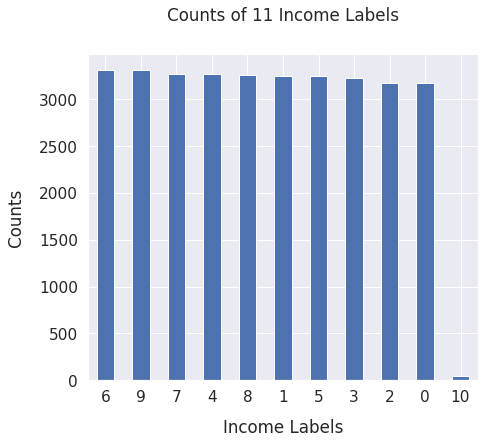

In [67]:
sns.set(font_scale=1.4)
y.value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Income Labels", labelpad=14)
plt.ylabel("Counts", labelpad=14)
plt.title("Counts of 11 Income Labels\n", y=1.02);

### Feature Engineering

In [68]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [69]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']
for feature in categorical:
        le =  preprocessing.LabelEncoder()
        x_train[feature] =  le.fit_transform(x_train[feature])
        x_test[feature] =  le.transform(x_test[feature])

In [70]:
x_train[categorical].head()

,workclass,marital.status,occupation,relationship,sex,native.country
32098,7,2,4,5,0,39
25206,2,2,7,0,1,39
23491,4,4,4,1,0,39
12367,2,4,5,3,1,39
7054,1,2,4,0,1,39


### Light GBM 을 이용하여 다중분류 구현하기

In [71]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm =  LGBMClassifier( )
lgbm.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Light GBM 다중분류 결과 확인하기: Accuracy, Confusion Matrix, Heatmap

In [73]:
## 정확도 구하기
y_pred1 =  lgbm.predict(x_test)

lgbm_score =  accuracy_score(y_test, y_pred1)
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))

LGBM Model accuracy score : 0.8119


In [74]:
pd.DataFrame(y_test).head(10)

,income.num
22278,6
8950,6
7838,7
16505,3
19140,2
12319,7
28589,7
10000,1
28530,3
24237,6


In [75]:
pd.DataFrame(y_pred1).head(10)

,0
0,6
1,6
2,7
3,1
4,3
5,7
6,7
7,1
8,3
9,6


In [76]:
## Confusion Matrix 확인하기
from sklearn.metrics import confusion_matrix
cm1 =  confusion_matrix(y_test, y_pred1)
print('LGBM Confusion Matrix for 11-class Labels\n')
print(cm1)


LGBM Confusion Matrix for 11-class Labels

[[934  41   4   3   1   0   2   3   0   0   0]
 [ 40 869  46  13   1   0   0   0   0   0   0]
 [ 23  42 807  45   7   0   2   2   0   2   0]
 [ 13  20  75 838  62   6   2   2   1   0   0]
 [ 11  17  16  73 758  70  12   4   5   3   0]
 [  8  13  18  22  76 758  78  12  11   6   0]
 [ 10   7  11  12  11  92 702  78  13  15   0]
 [ 12   8  10   8  11  12  77 730  91  23   0]
 [  7  10  10   6   9   7  12 102 727  88   0]
 [  8   7  10  16  16   6   7  29  62 808   0]
 [  0   0   0   0   0   0   0   0   0  12   0]]


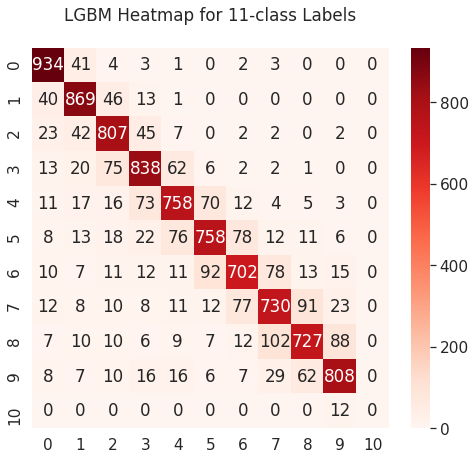

In [77]:
## 히트맵으로 시각화하기
plt.figure(figsize=[8,7])
sns.heatmap(cm1, cmap='Reds', annot=True, fmt='.0f')
plt.title('LGBM Heatmap for 11-class Labels\n')
plt.show()

In [78]:
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))
print('\n')
print(classification_report(y_test, y_pred1))

LGBM Model accuracy score : 0.8119


              precision    recall  f1-score   support

           0       0.88      0.95      0.91       988
           1       0.84      0.90      0.87       969
           2       0.80      0.87      0.83       930
           3       0.81      0.82      0.82      1019
           4       0.80      0.78      0.79       969
           5       0.80      0.76      0.78      1002
           6       0.79      0.74      0.76       951
           7       0.76      0.74      0.75       982
           8       0.80      0.74      0.77       978
           9       0.84      0.83      0.84       969
          10       0.00      0.00      0.00        12

    accuracy                           0.81      9769
   macro avg       0.74      0.74      0.74      9769
weighted avg       0.81      0.81      0.81      9769



### Random Forest 모델로 다중분류 구현하고 정확도 확인하기

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc =  RandomForestClassifier() 
rfc.fit(x_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
y_pred = rfc.predict(x_test)
rfc_score = accuracy_score(y_test, y_pred)
print('Random Forest Model accuracy score : {0:0.4f}'. format(rfc_score))

Random Forest Model accuracy score : 0.7693


## 다중분류 모델의 평가와 개선
###  Random Forest 다중분류 모델의 정확도 확인하기


In [81]:
## 이전 Step 복습
y_pred = rfc.predict(x_test)
rfc_score = accuracy_score(y_test, y_pred)
print('Randoom Forest Model accuracy score : {0:0.4f}'. format(rfc_score)) 

Randoom Forest Model accuracy score : 0.7693


### Random Forest 다중분류 모델의 인접정확도 구하기

In [82]:
## 인접 정확도의 계산
precise_accuracy =  np.sum(y_pred==y_test) / len(y_pred)
adjacent_accuracy =  np.sum(np.abs(y_pred - y_test) <= 1) / len(y_pred)

print('precise accuracy: {0:0.4f}'. format(precise_accuracy))
print('adjacent accuracy: {0:0.4f}'. format(adjacent_accuracy))

precise accuracy: 0.7693
adjacent accuracy: 0.9304


### Random Forest 다중분류 모델의 Confusion Matrix 확인하기

In [83]:
print(cm1) # light gbm 

[[934  41   4   3   1   0   2   3   0   0   0]
 [ 40 869  46  13   1   0   0   0   0   0   0]
 [ 23  42 807  45   7   0   2   2   0   2   0]
 [ 13  20  75 838  62   6   2   2   1   0   0]
 [ 11  17  16  73 758  70  12   4   5   3   0]
 [  8  13  18  22  76 758  78  12  11   6   0]
 [ 10   7  11  12  11  92 702  78  13  15   0]
 [ 12   8  10   8  11  12  77 730  91  23   0]
 [  7  10  10   6   9   7  12 102 727  88   0]
 [  8   7  10  16  16   6   7  29  62 808   0]
 [  0   0   0   0   0   0   0   0   0  12   0]]


In [84]:
from sklearn.metrics import confusion_matrix
cm2 =  confusion_matrix(y_test, y_pred)
print('Random Forest Confusion Matrix for 11-class Labels\n')
print(cm2)

Random Forest Confusion Matrix for 11-class Labels

[[934  46   5   1   1   0   1   0   0   0   0]
 [ 55 823  70  10   4   5   2   0   0   0   0]
 [ 24  71 783  36   8   1   3   0   2   2   0]
 [ 18  19  93 779  83   9   6   3   6   3   0]
 [ 13  19  14  88 725  86  15   2   3   4   0]
 [ 14  12  16  20  92 724  96  15   7   6   0]
 [ 12  11   9  10  21  94 690  86  10   8   0]
 [ 13   6  10   7  13  23  96 688 108  18   0]
 [  7  10  10   8  10  17  25 124 640 127   0]
 [ 11   5  12   9  19  18  18  37 111 729   0]
 [  0   0   0   0   0   0   0   0   0  12   0]]


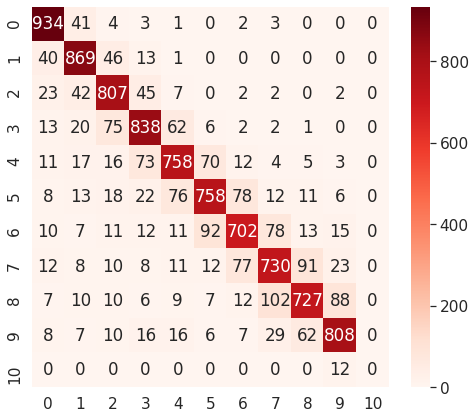

In [85]:
plt.figure(figsize=[8, 7])
sns.heatmap(cm1, cmap='Reds', annot=True, fmt='.0f')
plt.show()

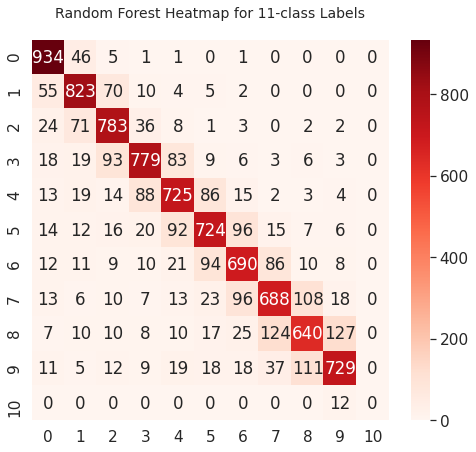

In [86]:
## Seaborn Heatmap

plt.figure(figsize=[8, 7])
sns.heatmap(cm2, cmap='Reds', annot=True, fmt='.0f')
plt.title('Random Forest Heatmap for 11-class Labels\n', fontsize=14)
plt.show()

### Random Forest 다중분류 모델의 분류결과 확인하기

In [87]:
from sklearn.metrics import classification_report

print('Random Forest precise  accuracy for 11 labels: {0:0.4f}'. format(precise_accuracy))
print('Random Forest adjacent accuracy for 11 labels: {0:0.4f}'. format(adjacent_accuracy))
print('\n')
print(classification_report(y_test, y_pred ))

Random Forest precise  accuracy for 11 labels: 0.7693
Random Forest adjacent accuracy for 11 labels: 0.9304


              precision    recall  f1-score   support

           0       0.85      0.95      0.89       988
           1       0.81      0.85      0.83       969
           2       0.77      0.84      0.80       930
           3       0.80      0.76      0.78      1019
           4       0.74      0.75      0.75       969
           5       0.74      0.72      0.73      1002
           6       0.72      0.73      0.73       951
           7       0.72      0.70      0.71       982
           8       0.72      0.65      0.69       978
           9       0.80      0.75      0.78       969
          10       0.00      0.00      0.00        12

    accuracy                           0.77      9769
   macro avg       0.70      0.70      0.70      9769
weighted avg       0.77      0.77      0.77      9769



### 적절한 클래스 수로 변환하여 모델 개선하기

In [88]:
def value_change(x):
    if x <= 20000: return 0
    if x >  20000 and x <= 50000 : return 1
    if x >  50000 and x <= 70000 : return 2
    if x >  70000 and x <= 90000 : return 3 
    return 4
                                       ## Define new function
y = data['income.num'].apply(lambda x: value_change(x))   ## Apply Lambda function

In [89]:
y.value_counts()

1    9686
2    6564
3    6533
0    6426
4    3352
Name: income.num, dtype: int64

In [90]:
y.value_counts().sum()

32561

In [91]:
9686 / 32561

0.29747243635023496

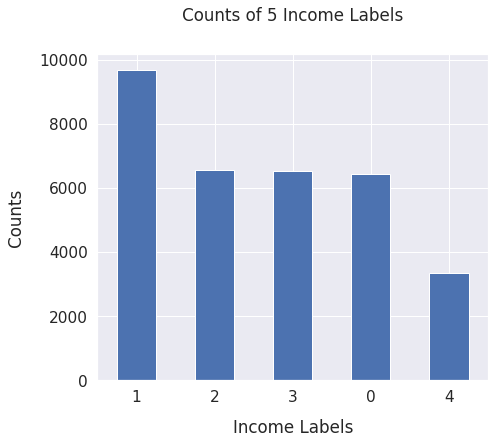

In [92]:
sns.set(font_scale=1.4)
y.value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Income Labels", labelpad=14)
plt.ylabel("Counts", labelpad=14)
plt.title("Counts of 5 Income Labels\n", y=1.02);

### Feature Engineering

In [93]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [94]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        x_train[feature] = le.fit_transform(x_train[feature])
        x_test[feature] = le.transform(x_test[feature])

### 변경한 클래스를 이용한 Random Forest 다중분류 모델의 개선결과 확인하기

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(random_state=0)
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [96]:
## Confusion Matrix 확인하기
y_pred =  rfc.predict(x_test)
cm3 =  confusion_matrix(y_test, y_pred)
print('Random Forest Confusion Matrix for 5-class Labels\n')
print(cm3)

Random Forest Confusion Matrix for 5-class Labels

[[1811  144    2    0    0]
 [ 105 2721   84    8    0]
 [  31  194 1609  118    1]
 [  26   81  134 1680   39]
 [  13   56   29  253  630]]


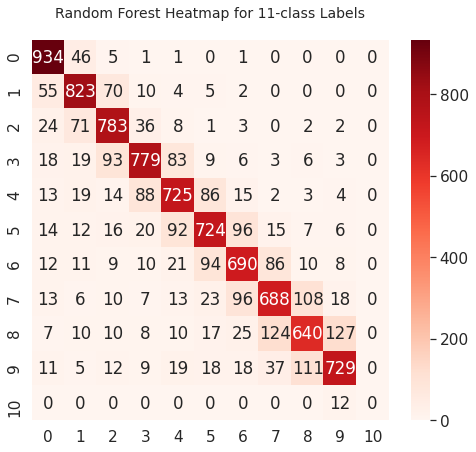

In [97]:
plt.figure(figsize=[8, 7])
sns.heatmap(cm2, cmap='Reds', annot=True, fmt='.0f')
plt.title('Random Forest Heatmap for 11-class Labels\n', fontsize=14)
plt.show()

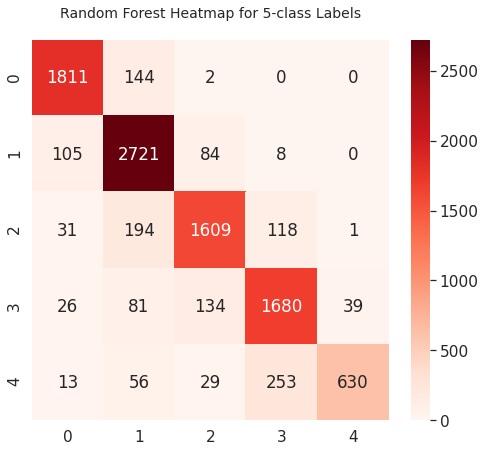

In [98]:
# Heatmap 그려보기

plt.figure(figsize=[8,7])
sns.heatmap(cm3, cmap="Reds", annot=True, fmt='.0f')
plt.title('Random Forest Heatmap for 5-class Labels\n', fontsize=14)
plt.show()

In [99]:
## Accruacy Evaluation
precise_accuracy =  np.sum(y_pred==y_test) / len(y_pred) # exact_match
adjacent_accuracy =  np.sum(np.abs(y_pred - y_test) <=1) / len(y_pred)

print('precise accuracy: {0:0.4f}'. format(precise_accuracy))
print('adjacent accuracy: {0:0.4f}'. format(adjacent_accuracy))

precise accuracy: 0.8651
adjacent accuracy: 0.9747


In [100]:
## 2가지 Accruacy 스코어의 비교
print('Random Forest precise  accuracy for 5 labels: {0:0.4f}'. format(precise_accuracy))
print('Random Forest adjacent accuracy for 5 labels: {0:0.4f}'. format(adjacent_accuracy))
print('\n')
print(classification_report(y_test, y_pred))

Random Forest precise  accuracy for 5 labels: 0.8651
Random Forest adjacent accuracy for 5 labels: 0.9747


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1957
           1       0.85      0.93      0.89      2918
           2       0.87      0.82      0.84      1953
           3       0.82      0.86      0.84      1960
           4       0.94      0.64      0.76       981

    accuracy                           0.87      9769
   macro avg       0.88      0.84      0.85      9769
weighted avg       0.87      0.87      0.86      9769



### 변경한 클래스를 이용한 Ligth GBM 다중분류 모델의 개선결과 확인하기

In [101]:
lgbm =  LGBMClassifier(random_state=0)
lgbm.fit(x_train, y_train)
y_pred1 =  lgbm.predict(x_test)

lgbm_score1 = accuracy_score(y_test, y_pred1 )
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score1))

LGBM Model accuracy score : 0.9023


In [102]:
## Confusion Matrix 구하기

cm4 =  confusion_matrix(y_test, y_pred1)
print('LGBM Confusion Matrix for 5-class Labels\n')
print(cm4)

LGBM Confusion Matrix for 5-class Labels

[[1859   91    3    4    0]
 [  77 2770   60    9    2]
 [  28  145 1685   91    4]
 [  26   60  104 1717   53]
 [  13   38   20  126  784]]


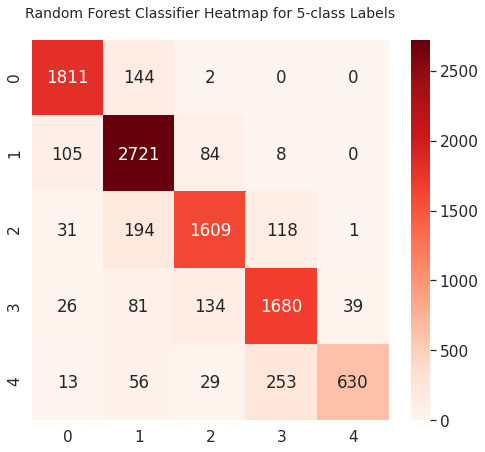

In [103]:
# seaborn를 이용한 heatmap

plt.figure(figsize=[8, 7])
sns.heatmap(cm3, cmap='Reds', annot=True, fmt='.0f')
plt.title('Random Forest Classifier Heatmap for 5-class Labels\n', fontsize=14)
plt.show()

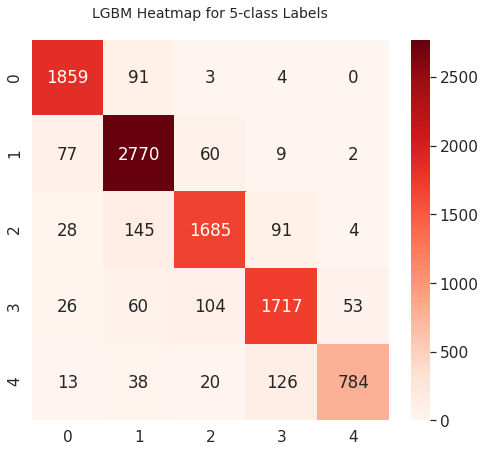

In [104]:
# seaborn를 이용한 heatmap

plt.figure(figsize=[8, 7])
sns.heatmap(cm4, cmap='Reds', annot=True, fmt='.0f')
plt.title('LGBM Heatmap for 5-class Labels\n', fontsize=14)
plt.show()

In [105]:
## Accuracy Evalaution
precise_accuracy1 =  np.sum(y_pred1 == y_test) / len(y_pred1) # exact_match
adjacent_accuracy1 =  np.sum(np.abs(y_pred1 - y_test) <= 1) / len(y_pred1) 

print('LGBM precise  accuracy for 5 labels: {0:0.4f}'. format(precise_accuracy1))
print('LGBM adjacent accuracy for 5 labels: {0:0.4f}'. format(adjacent_accuracy1))
print('\n')
print(classification_report(y_test, y_pred1))

LGBM precise  accuracy for 5 labels: 0.9023
LGBM adjacent accuracy for 5 labels: 0.9788


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1957
           1       0.89      0.95      0.92      2918
           2       0.90      0.86      0.88      1953
           3       0.88      0.88      0.88      1960
           4       0.93      0.80      0.86       981

    accuracy                           0.90      9769
   macro avg       0.91      0.89      0.90      9769
weighted avg       0.90      0.90      0.90      9769



## 요약: 소득 다중분류 예측모델의 결과 비교하기

In [106]:
print ('Accuracy Comparisons for Multiclass Models\n')
print ('rfc_score  (11 labels)  :', '{0:0.5f}'.format(rfc_score)) 
print ('rfc_score  ( 5 labels)  :', '{0:0.5f}'.format(precise_accuracy))
print ('lbgm_score (11 labels)  :', '{0:0.5f}'.format(lgbm_score)) 
print ('lgbm_score ( 5 labels)  :', '{0:0.5f}'.format(precise_accuracy1)) 

Accuracy Comparisons for Multiclass Models

rfc_score  (11 labels)  : 0.76927
rfc_score  ( 5 labels)  : 0.86508
lbgm_score (11 labels)  : 0.81185
lgbm_score ( 5 labels)  : 0.90234


In [107]:
print('LGBM Confusion Matrix')
print(cm1)
print('\n')
print('Random Forest Confusion Matrix')
print(cm2)

LGBM Confusion Matrix
[[934  41   4   3   1   0   2   3   0   0   0]
 [ 40 869  46  13   1   0   0   0   0   0   0]
 [ 23  42 807  45   7   0   2   2   0   2   0]
 [ 13  20  75 838  62   6   2   2   1   0   0]
 [ 11  17  16  73 758  70  12   4   5   3   0]
 [  8  13  18  22  76 758  78  12  11   6   0]
 [ 10   7  11  12  11  92 702  78  13  15   0]
 [ 12   8  10   8  11  12  77 730  91  23   0]
 [  7  10  10   6   9   7  12 102 727  88   0]
 [  8   7  10  16  16   6   7  29  62 808   0]
 [  0   0   0   0   0   0   0   0   0  12   0]]


Random Forest Confusion Matrix
[[934  46   5   1   1   0   1   0   0   0   0]
 [ 55 823  70  10   4   5   2   0   0   0   0]
 [ 24  71 783  36   8   1   3   0   2   2   0]
 [ 18  19  93 779  83   9   6   3   6   3   0]
 [ 13  19  14  88 725  86  15   2   3   4   0]
 [ 14  12  16  20  92 724  96  15   7   6   0]
 [ 12  11   9  10  21  94 690  86  10   8   0]
 [ 13   6  10   7  13  23  96 688 108  18   0]
 [  7  10  10   8  10  17  25 124 640 127   0]
 [ 1

In [108]:
print ('Classification Comparions for Multiclass Models\n')
print ('rfc_score   :', '{0:0.4f}'.format(rfc_score))
print (classification_report(y_test, y_pred))
print ('lgbm_score  :', '{0:0.4f}'.format(lgbm_score))
print (classification_report(y_test, y_pred1))

Classification Comparions for Multiclass Models

rfc_score   : 0.7693
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1957
           1       0.85      0.93      0.89      2918
           2       0.87      0.82      0.84      1953
           3       0.82      0.86      0.84      1960
           4       0.94      0.64      0.76       981

    accuracy                           0.87      9769
   macro avg       0.88      0.84      0.85      9769
weighted avg       0.87      0.87      0.86      9769

lgbm_score  : 0.8119
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1957
           1       0.89      0.95      0.92      2918
           2       0.90      0.86      0.88      1953
           3       0.88      0.88      0.88      1960
           4       0.93      0.80      0.86       981

    accuracy                           0.90      9769
   macro avg       0.91      0.89      0

##  요약

- 1) 이진분류·다중분류 모델의 이해<p>: 분류 항목의 수에 따라 달라지는 모델링 방법(파라미터 처리)

- 2) 선형 기반·트리 기반 분류모델의 이해<p>: Logistic Regression, Random Forest, Gradient Boosting, <strong>Light GBM</strong> 등


- 3) 변수 처리 방법에 대한 이해<p>: 범주변수 처리, 스케일 조정, 3개 이상의 클래스 처리


- 4) 분류모델 결과를 해석하는 방법 습득<p>: 단순정확도, <b>인접정확도</b>, Precision, Recall  등


- 5) 평가결과를 바탕으로 모델을 개선하는 방법 습득<p>: F1 스코어, Confusion Matrix, Classification Report 등을 종합적으로 이용